In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from sklearn import metrics
from sklearn.decomposition import PCA
import tabulate
import itertools
import igraph as ig
import matplotlib.patches as mpatches
from sklearn.neighbors import radius_neighbors_graph
from scipy.ndimage import gaussian_filter1d
from sklearn.neighbors import kneighbors_graph
from scipy.spatial.distance import pdist, squareform
import leidenalg as la
import dask.array as da
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import umap
import bbknn
import bbknn.matrix
from importlib import reload
from scipy import stats
import matplotlib.image as mpimg
import goatools
from goatools.anno.gaf_reader import GafReader
import Bio.UniProt.GOA as GOA
import gget

# locals
import utils as ut
reload(ut)

2022-12-22 08:30:26.605289: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-22 08:30:34.685082: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/slurm/lib64:
2022-12-22 08:30:34.685105: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-22 08:30:35.472187: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-22 08:30:43.7932

<module 'utils' from '/home/cstansbu/git_repositories/spatial_transcriptomics/clustering/utils.py'>

In [2]:
# load cluster assignments
cdf = pd.read_csv("clusterAssignments.csv")
cid = {}

for key in cdf['key'].unique():
    t = cdf[cdf['key'] == key]
    cid[key] = t
    
print('done')

done


In [3]:
dirPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/scanpy/"

adata = {}

for f in os.listdir(dirPath):
    
    if f.endswith('.h5ad'):
        key = f.split(".")[0]
        fullPath = f"{dirPath}{f}"
        data = sc.read(fullPath)
        adata[key] = data
    
print("done")

done


In [4]:
keys = ['ND', 'HFD8', 'HFD14']
ctypes = ['Macrophages', 'Monocytes']
ctypes = ['Macrophages']

res = []
refs = []

for key in keys:
    data = adata[key]
    
    # get the run key
    allKeys = list(data.obs.keys() )
    allKeys.remove('n_genes')
    runKey = allKeys[0]
    
    clusterIds = data.obs[runKey].astype(int) + 1  # note that these are zero-indexed!
    # get number of clusterss
    k = data.obs[runKey].nunique() + 1
    colorlist = ut.ncolor(k, cmap='Spectral')
    df = data.to_df()
    
    # get all clusters for the cell type
    cellTypes = cid[key]
    
    for ctype in ctypes:
        cellTypeIds = cellTypes[cellTypes['cellType'] == ctype]['clusterId'].to_numpy()
        mask = clusterIds.isin(cellTypeIds)
        
        # extract cells
        cells = df[mask]
        print(cells.shape)
        
        # extract cell ids
        r = pd.DataFrame(cells.index)
        r.columns = ['CellId']
        r['key'] = key
        r['ctype'] = ctype
        
        res.append(cells)
        refs.append(r)

        
res = pd.concat(res, ignore_index=True)
print(f"{res.shape=}")
refs = pd.concat(refs, ignore_index=True)
print(f"{refs.shape=}")

print(refs['ctype'].value_counts(normalize=True))
print()
res.head()

(359, 12490)
(2188, 13768)
(3884, 13479)
res.shape=(6431, 14205)
refs.shape=(6431, 3)
Macrophages    1.0
Name: ctype, dtype: float64



MRPL15    LYPLA1     TCEA1   ATP6V1H    RB1CC1  4732440D04RIK  PCMTD1  \
0  0.000000  0.000000  1.540236  0.000000  1.540236            0.0     0.0   
1  0.000000  0.000000  0.000000  0.000000  1.167320            0.0     0.0   
2  0.751568  0.000000  0.000000  0.751568  0.000000            0.0     0.0   
3  0.000000  0.000000  0.000000  0.000000  0.619184            0.0     0.0   
4  0.000000  1.463523  1.463523  0.000000  0.000000            0.0     0.0   

   RRS1  MYBL1  VCPIP1  ...  KATNAL2  SIGLEC15  BBS1  PELI3  CST6  GM10353  \
0   0.0    0.0     0.0  ...      NaN       NaN   NaN    NaN   NaN      NaN   
1   0.0    0.0     0.0  ...      NaN       NaN   NaN    NaN   NaN      NaN   
2   0.0    0.0     0.0  ...      NaN       NaN   NaN    NaN   NaN      NaN   
3   0.0    0.0     0.0  ...      NaN       NaN   NaN    NaN   NaN      NaN   
4   0.0    0.0     0.0  ...      NaN       NaN   NaN    NaN   NaN      NaN   

   SCGB1A1  MS4A2  LIPN  SLIT1  
0      NaN    NaN   NaN    NaN  
1      NaN    NaN   NaN    NaN  
2      NaN    NaN   NaN    NaN  
3      NaN    NaN   NaN    NaN  
4      NaN    NaN   NaN    NaN  

[5 rows x 14205 columns]

Removed 5901 Genes with STD < 0.2
Retained: 8304
Xpca.shape=(6431, 40)
distances.shape=(6431, 6431)
connectivies.shape=(6431, 6431)


Text(0.5, 1.0, 'Macrophages')

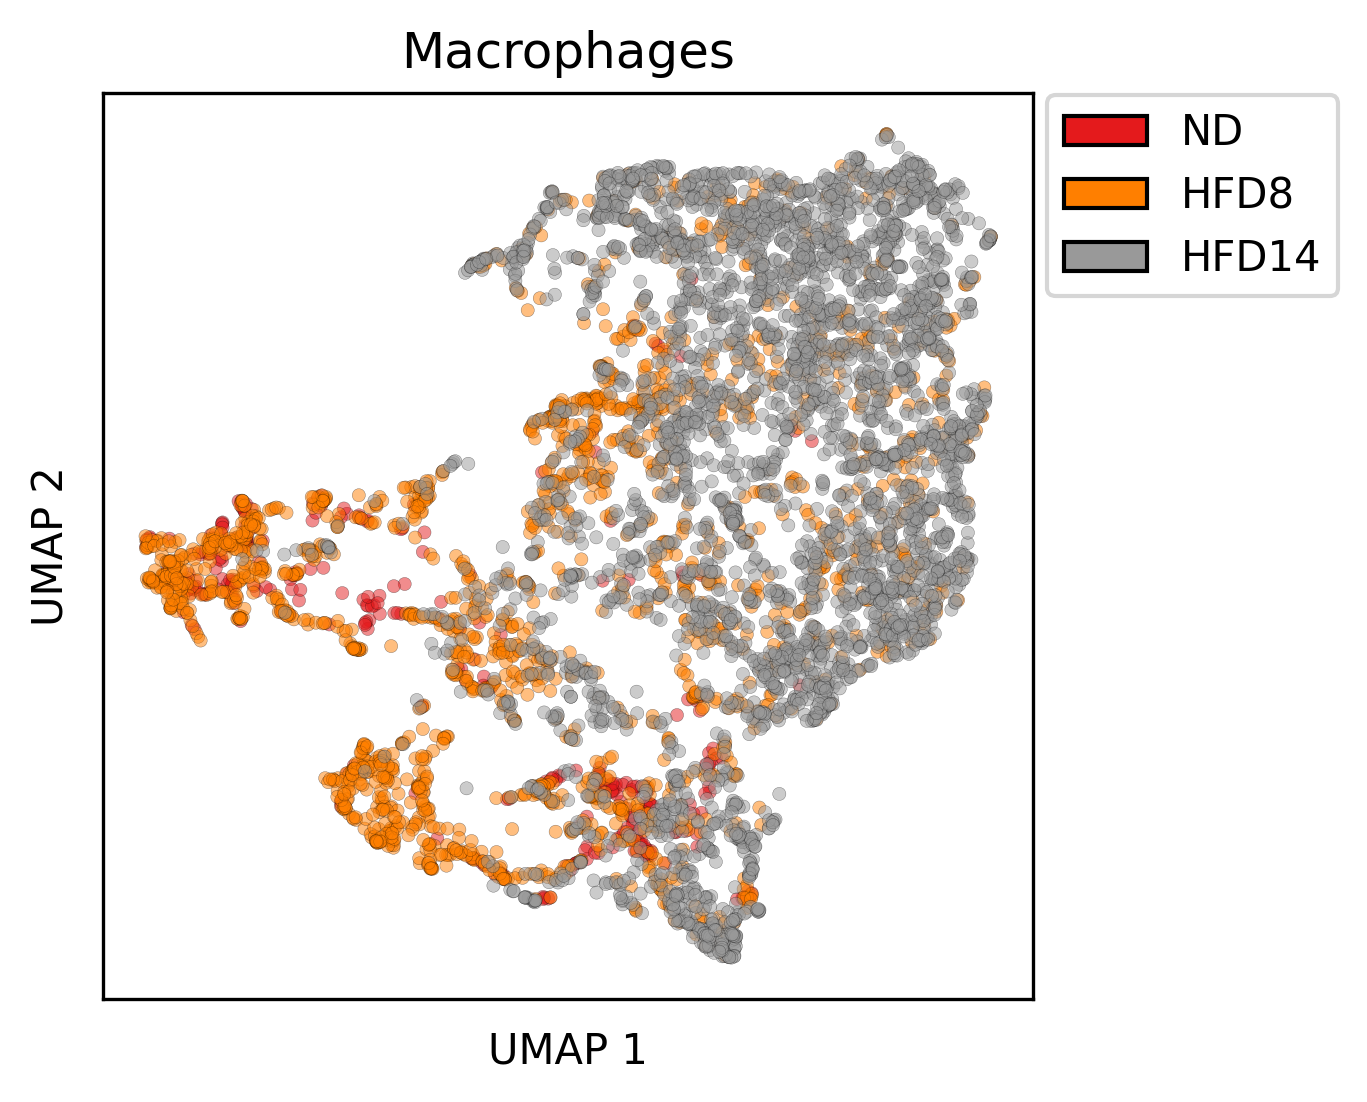

In [24]:
"""create a low-dimensional embedding for visualization """
X = res.fillna(0)
totalG = X.shape[1]

# remove low variance genes
stdT = 0.2
geneStd = X.std(axis=0)
mask = geneStd < stdT
X = X[X.columns[~mask]]
g = X.shape[1]
print(f"Removed {totalG - g} Genes with STD < {stdT}")
print(f"Retained: {g}")


"""
BBKNN
"""
r = 40
pca = PCA(n_components=r)
pcaModel = pca.fit(X)
Xpca = pca.fit_transform(X)
print(f"{Xpca.shape=}")

distances, connectivies, parameters = bbknn.matrix.bbknn(Xpca, refs['key'].to_list())

print(f"{distances.shape=}")
print(f"{connectivies.shape=}")


# plotting params
n_components = 2 # should always be 2
n_neighbors = 6
min_dist = 0.1
metric= "euclidean"

umap_reducer = umap.UMAP(n_components=n_components,
                         n_neighbors=n_neighbors,
                         min_dist=min_dist,
                         metric=metric)

embedding = umap_reducer.fit_transform(connectivies) # we need embedding by cell
embedding = pd.DataFrame(embedding)
embedding.columns = ['x', 'y']


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 4, 4

"""add color information """

colorBy = 'key'
cmap = 'Set1'

colors = ut.ncolor(refs[colorBy].nunique(), cmap=cmap)
colors = dict(zip(refs[colorBy].unique(), colors))

handles = []

for label, color in colors.items():
    handle = mpatches.Patch(color=color, 
                            ec='k', 
                            label=f"{label}")
    
    handles.append(handle)
    
refs[f'color'] = refs[colorBy].map(colors)

plt.scatter(embedding['x'],
            embedding['y'], 
            marker=".",
            s=40,
            edgecolor='k',
            lw=0.1,
            c=refs[f'color'].to_list(),
            alpha=0.5)

plt.legend(handles=handles, bbox_to_anchor=(1.35, 1.02))
_ = plt.xticks([])
_ = plt.yticks([])

plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title(f"{ctype}")

In [6]:
# break

In [7]:
# """Estimate the rank of the data matrix: WARNING takes a long time """
# # remove low variance genes
# stdT = 0.2
# X = res.fillna(0)
# geneStd = X.std(axis=0)
# mask = geneStd < stdT
# X = X[X.columns[~mask]]
# X = X.to_numpy()
# print(f"{X.shape=}")

# # _ = plt.hist(geneStd, 
# #              bins=30,
# #              color="lightgrey", 
# #              edgecolor="k")

# # plt.xlabel(r"Expression Variability ($\sigma$)")
# # plt.ylabel("Number of Genes")
# # plt.show()

# u, s, vh = np.linalg.svd(X)
# print(f"{u.shape=}, {s.shape=}, {vh.shape=}")

# def getOHT(u, s, vh):
#     m = u.shape[0]
#     n = vh.shape[0] 
#     beta = m / n
#     omega = (0.56*beta**3) - (0.95 * beta**2) + (1.82 * beta) + 1.43
#     y_med = np.median(s)
#     tau = omega * y_med
#     s_ind = np.argwhere(s >= tau)
#     oht = np.max(s_ind) 
#     return oht, tau

# oht, tau = getOHT(u, s, vh)
# print(f"{oht=} {tau=}")

# sNorm = s.copy()
# sNorm /= np.max(sNorm)

# xp = [x/s.sum() for x in s]
# cumXp = np.cumsum(xp)
# over80 = np.min(np.argwhere(cumXp > 0.8))
# print(f"{over80=}")

# # smooth
# smooth = gaussian_filter1d(sNorm, 3)

# # compute second derivative
# smooth_d2 = np.gradient(np.gradient(smooth))
# infl = np.min(np.where(np.diff(np.sign(smooth_d2)))[0]) - 1 
# print(f"{infl=}")

# eigengap = np.argmax(np.abs(np.diff(s[:30]))) + 2
# print(f"{eigengap=}")

# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.facecolor'] = "w"
# plt.rcParams['figure.figsize'] = 4, 2

# plt.plot(range(len(s)), 
#          s, 
#          lw=1, 
#          c="k")

# plt.yscale("log")
# plt.ylabel("Magnitude")
# plt.xlabel("Singular Value")

# plt.scatter(eigengap,
#             s[eigengap],
#             marker=".",
#             c='b', 
#             ec='k',
#             lw=1,
#             s=90,
#             label=f"eigengap={eigengap}")


# plt.scatter(oht,
#             s[oht+1],
#             marker=".",
#             c='red', 
#             ec='k',
#             lw=1,
#             s=90,
#             label=f"OHT={oht+1}")

# # plt.scatter(over80,
# #             s[over80+1],
# #             marker=".",
# #             c='green', 
# #             ec='k',
# #             lw=1,
# #             s=90,
# #             label=f"80%={over80+1}")

# # plt.scatter(infl,
# #             s[infl],
# #             marker=".",
# #             c='green', 
# #             ec='k',
# #             lw=1,
# #             s=90,
# #             label=f"min f''(s)={infl}")

# plt.legend()
# plt.title(f"X dim {X.shape}, sigmaT={stdT}")

In [8]:
# t = 20
# plt.plot(range(len(s[:t])), 
#          s[:t], 
#          lw=1,
#          marker=".",
#          c="k")

# plt.ylabel("Magnitude")
# plt.xlabel(f"First {t} Singular Values")

In [9]:
# break

In [10]:
def getDistanceMatrix(X, r=15, metric='euclidean', returnExp=False):
    """A function to compute pairwise distances from scRNA data """    
    # compute the PCA 
    pca = PCA(n_components=r)
    pcaModel = pca.fit(X)
    Xpca = pca.fit_transform(X)
    
    # compute pairwise similarity
    A = metrics.pairwise_distances(Xpca, metric=metric)
    
    if returnExp:
        exVar = pcaModel.explained_variance_
        xp = [x/exVar.sum() for x in exVar]
        cumXp = np.cumsum(xp)
        
        return A, cumXp
    else:
        return A

In [11]:
# t = 0.8
# rRange = np.linspace(5, 100, 50).astype(int)

# result = []

# for r in rRange:
#     A, ex = getDistanceMatrix(res.fillna(0), r=r)
#     huer = np.min(np.argwhere(ex >= t)) + 1 
    
#     row = {
#         "nPCA" : r,
#         "First" : ex[0],
#         f"Hueristic" : huer
#     }
#     result.append(row)
    
# result = pd.DataFrame(result)
# result.head()

# plt.scatter(result['nPCA'], 
#             result['Hueristic'])

X.shape=(6431, 8305)
(6431, 6431)


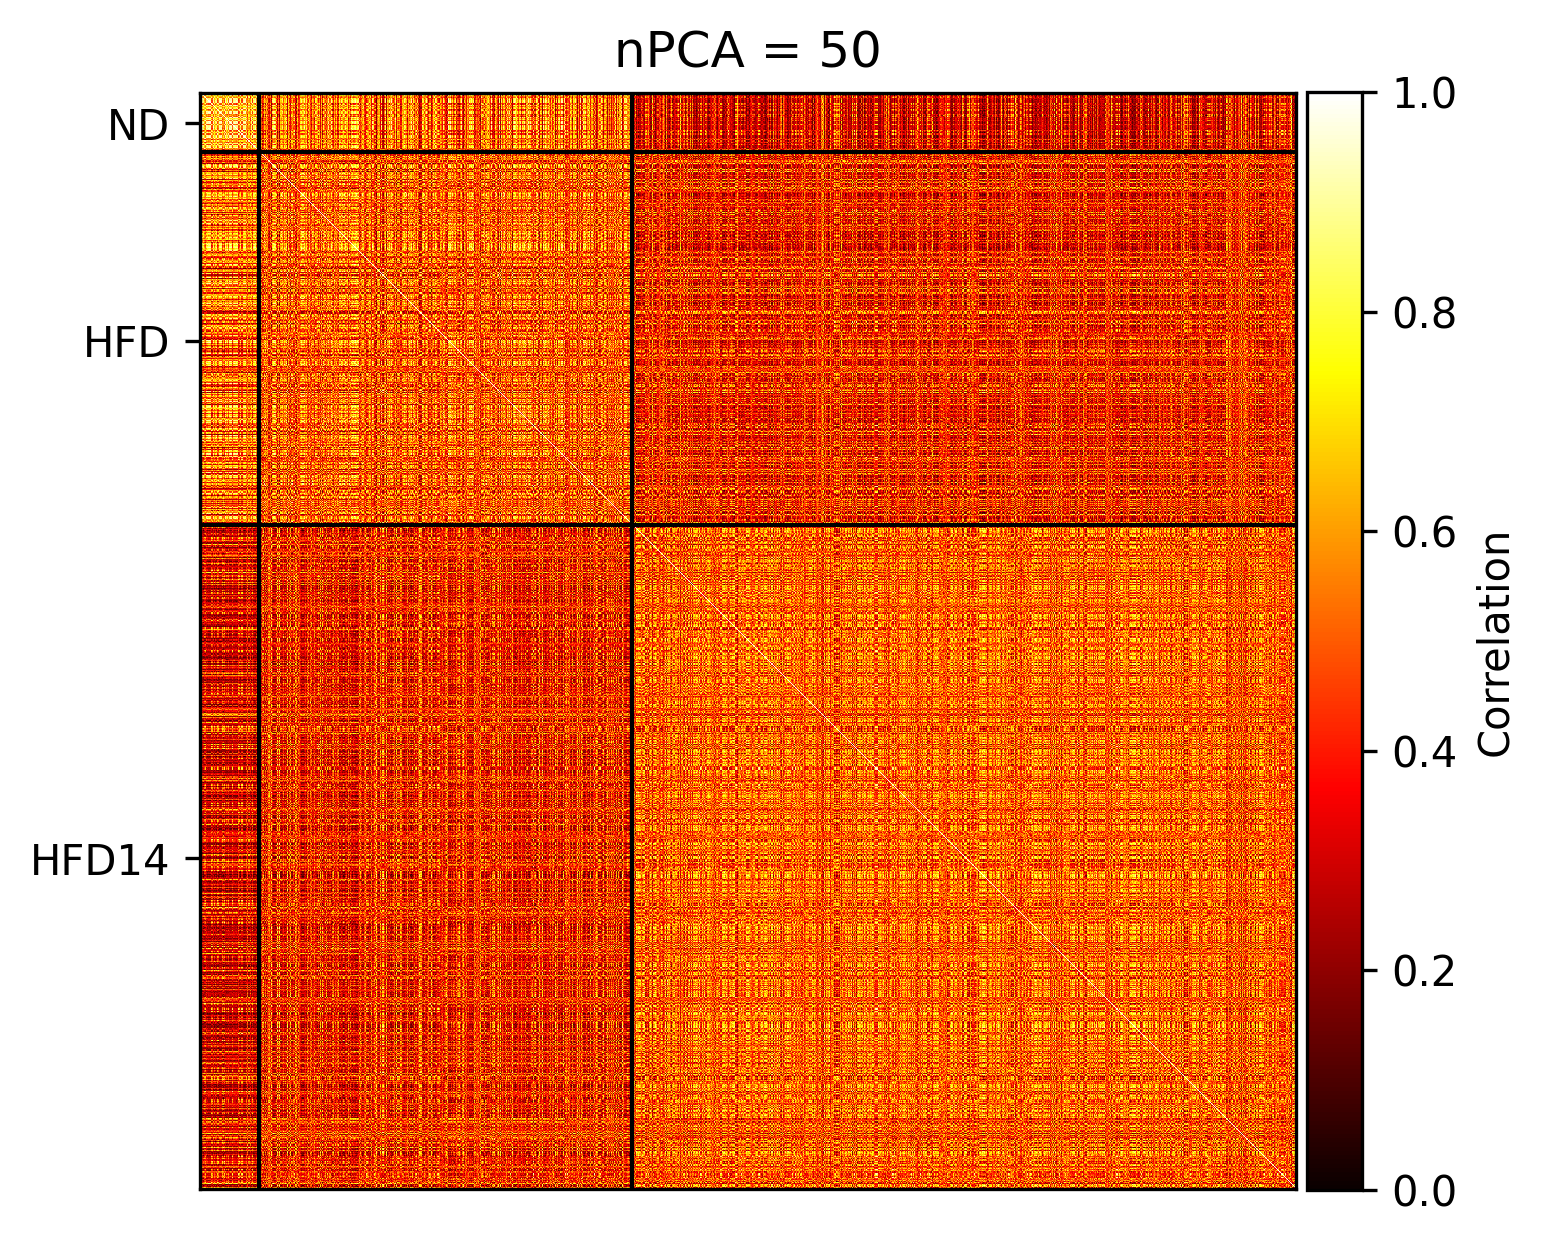

ND Mean 0.6669 (0.1785)
HFD Mean 0.4929 (0.1797)
HFD14 Mean 0.4990 (0.1642)


In [12]:
"""
Construct the distance matrix 
"""
metric='correlation'
r = 50

stdT = 0.2
X = res.fillna(0)
geneStd = X.std(axis=0)
mask = geneStd < stdT
X = X[X.columns[~mask]]
X = X.to_numpy()
print(f"{X.shape=}")

A = getDistanceMatrix(X, r=r, metric=metric)
print(A.shape)

Ahat = A.copy()
Ahat *= 1.0/Ahat.max() 
Ahat = 1 - Ahat # convert distance to similarity

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 5, 5

linc = "k"
lw = 1

plt.matshow(Ahat, cmap='hot')
_ = plt.xticks([])
plt.colorbar(fraction=0.0472, pad=0.01, label='Correlation')

buff = 10
boundaries = [359-buff, 2188+359-buff]
for b in boundaries:
    plt.axvline(x=b, c=linc, lw=lw)
    plt.axhline(y=b, c=linc, lw=lw)

    
locs = [359 / 2, (2188 / 2) + 359, (3884 / 2) + 359 + 2188]
plotLabel = ['ND', 'HFD', 'HFD14']
_ = plt.yticks(locs, plotLabel)     
plt.title(f"nPCA = {r}")

plt.show()

keyCount = 0
for i, j in [(0, 359), (359, 2188+259), (2188+259, 2188+259+3884)]:
    key = plotLabel[keyCount]
    keyCount += 1
    sub = Ahat[i:j, i:j]
    print(f"{key} Mean {sub.mean():.4f} ({sub.std():.4f})")


# for 

# lastType = 'Macrophages'

# labels = []
# ctL = []

# for ct in refs['ctype']:
#     if ct == lastType:
#         labels.append(0)
#     else:
#         ctL.append(lastType)
#         labels.append(1)
#         lastType = ct
        
# inx = np.nonzero(labels)[0]
# print(ctL)
# print(inx)

# locs = []

# lastInx = 0
# for i in inx:
#     plt.axvline(x=i, c=linc, lw=lw)
#     plt.axhline(y=i, c=linc, lw=lw)
    
#     endRange = ((i - lastInx) / 2) + lastInx
#     locs.append(endRange)
#     lastInx = i
    
# endRange = ((A.shape[0] - lastInx) / 2) + lastInx
# locs.append(endRange)

# plotLabel = ["ND Macrophages",
#              "ND Monocytes",
#              "HFD8 Macrophages",
#              "HFD8 Monocytes",
#              "HFD14 Macrophages",
#              "HFD14 Monocytes"]

# _ = plt.yticks(locs, plotLabel) 

In [13]:
# stdT = 0.2
# X = res.fillna(0)
# geneStd = X.std(axis=0)
# mask = geneStd < stdT
# X = X[X.columns[~mask]]
# X = X.to_numpy()
# print(f"{X.shape=}")

# # regress out batch effects
# r = 15
# pca = PCA(n_components=r)
# pcaModel = pca.fit(X)
# Xpca = pca.fit_transform(X)
# print(f"{Xpca.shape=}")

# distances, Abbknn, parameters = bbknn.matrix.bbknn(Xpca, refs['key'].to_list(), neighbors_within_batch=10)      
# Abbknn = Abbknn.todense()
# plt.spy(Abbknn, 
#         marker=".",
#         markersize=0.05)

# buff = 10
# boundaries = [359-buff, 2188+359-buff]
# for b in boundaries:
#     plt.axvline(x=b, c=linc, lw=lw)
#     plt.axhline(y=b, c=linc, lw=lw)

    
# locs = [359 / 2, (2188 / 2) + 359, (3884 / 2) + 359 + 2188]
# plotLabel = ['ND', 'HFD', 'HFD14']
# _ = plt.yticks(locs, plotLabel)     
# plt.title(f"nPCA = {r}")

# plt.show()

# keyCount = 0
# for i, j in [(0, 359), (359, 2188+259), (2188+259, 2188+259+3884)]:
#     key = plotLabel[keyCount]
#     keyCount += 1
#     sub = Ahat[i:j, i:j]
#     print(f"{key} Mean {sub.mean():.4f} ({sub.std():.4f})")


In [14]:
# ?bbknn.matrix.bbknn

In [15]:
# stdT = 0.2
# X = res.fillna(0)
# geneStd = X.std(axis=0)
# mask = geneStd < stdT
# X = X[X.columns[~mask]]
# X = X.to_numpy()
# print(f"{X.shape=}")

# sim = []

# for r in np.linspace(2, 30, 15).astype(int):
#     print(f"working... {r}")
#     A = getDistanceMatrix(X, r=r, metric=metric)

#     Ahat = A.copy()
#     Ahat *= 1.0/Ahat.max() 
#     Ahat = 1 - Ahat # convert distance to similarity
    
#     keyCount = 0
#     for i, j in [(0, 359), (359, 2188+259), (2188+259, 2188+259+3884)]:
#         key = plotLabel[keyCount]
#         keyCount += 1
#         sub = Ahat[i:j, i:j]
        
#         newRow = {
#             'nPCA' : r,
#             'mean' : sub.mean(),
#             'std' : sub.std(),
#             'Key' : key
#         }
#         sim.append(newRow)
        
# sim = pd.DataFrame(sim)

# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.facecolor'] = "w"
# plt.rcParams['figure.figsize'] = 5, 2

# sns.lineplot(data=sim,
#              x='nPCA',
#              y='mean', 
#              hue='Key')

# plt.ylabel('Mean Similarity')
# plt.xlabel('Number of Components')
# plt.legend(loc='upper right')

0.941069483757019


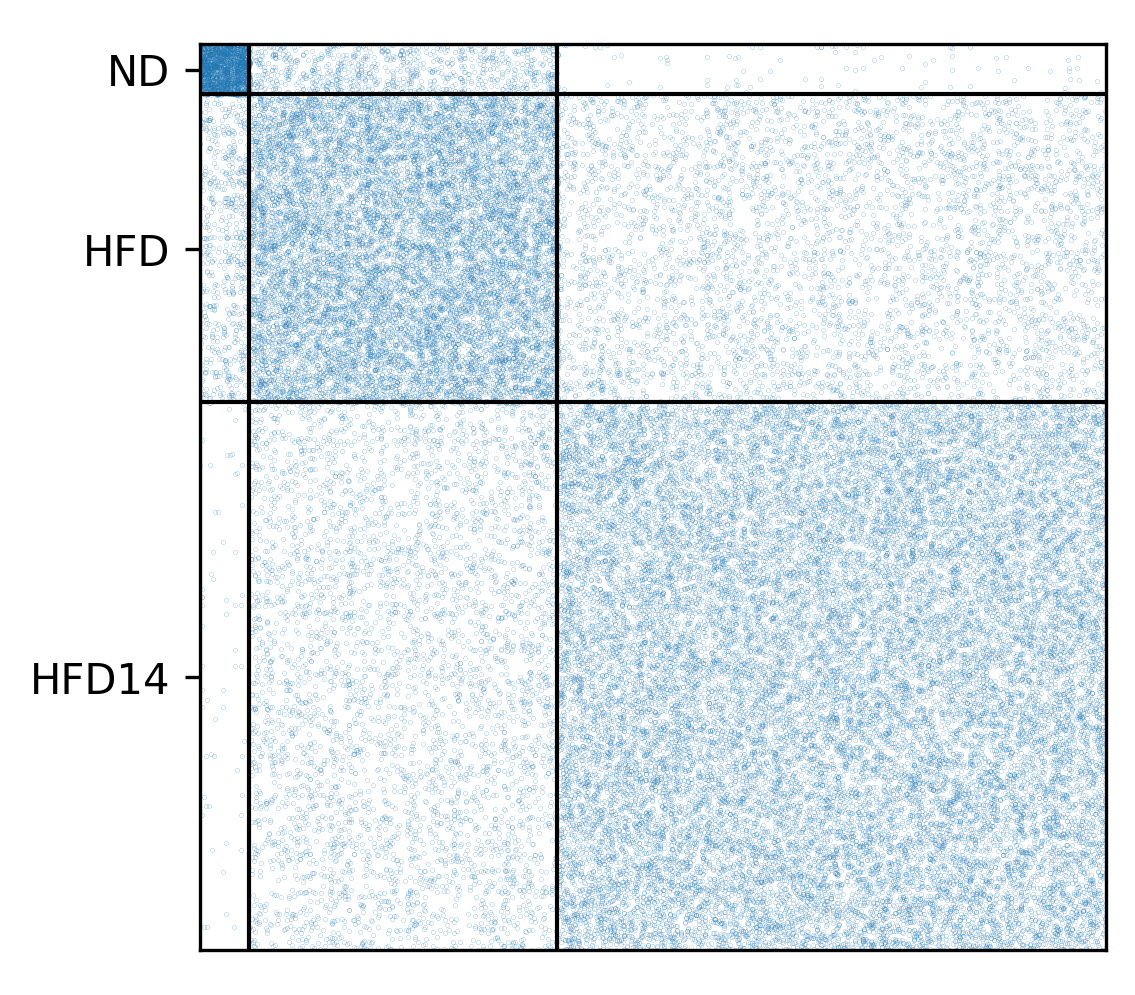

In [123]:
""" Construct the KNN graph"""
stdT = 0.15
X = res.fillna(0)
geneStd = X.std(axis=0)
mask = geneStd < stdT
X = X[X.columns[~mask]]
X = X.to_numpy()

""" get distances """
r = 25
A = getDistanceMatrix(X, r=r, metric=metric)
Ahat = A.copy()
Ahat *= 1.0/Ahat.max() 
Ahat = 1 - Ahat # convert distance to similarity


""" Construct the KNN graph"""
k = 8
knn = kneighbors_graph(Ahat, k)
x, y = np.nonzero(knn.todense())
Aknn = np.zeros(Ahat.shape)

Aknn[x, y] = Ahat[x, y]
print(Aknn.max())

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 4, 4
plt.spy(Aknn, 
        marker=".",
        markersize=0.1)

_ = plt.xticks([])

buff = 10
boundaries = [359-buff, 2188+359-buff]
for b in boundaries:
    plt.axvline(x=b, c=linc, lw=lw)
    plt.axhline(y=b, c=linc, lw=lw)
    
locs = [359 / 2, (2188 / 2) + 359, (3884 / 2) + 359 + 2188]
plotLabel = ['ND', 'HFD', 'HFD14']
_ = plt.yticks(locs, plotLabel)   

4    2203
0    2177
3     962
2     737
1     352
Name: Spectral, dtype: int64
==== 4 n=962===
HFD14    0.485447
HFD8     0.371102
ND       0.143451
Name: key, dtype: float64

==== 2 n=352===
HFD8     0.892045
ND       0.076705
HFD14    0.031250
Name: key, dtype: float64

==== 3 n=737===
HFD8     0.713704
ND       0.238806
HFD14    0.047490
Name: key, dtype: float64

==== 5 n=2203===
HFD14    0.752610
HFD8     0.243305
ND       0.004085
Name: key, dtype: float64

==== 1 n=2177===
HFD14    0.786863
HFD8     0.209003
ND       0.004134
Name: key, dtype: float64



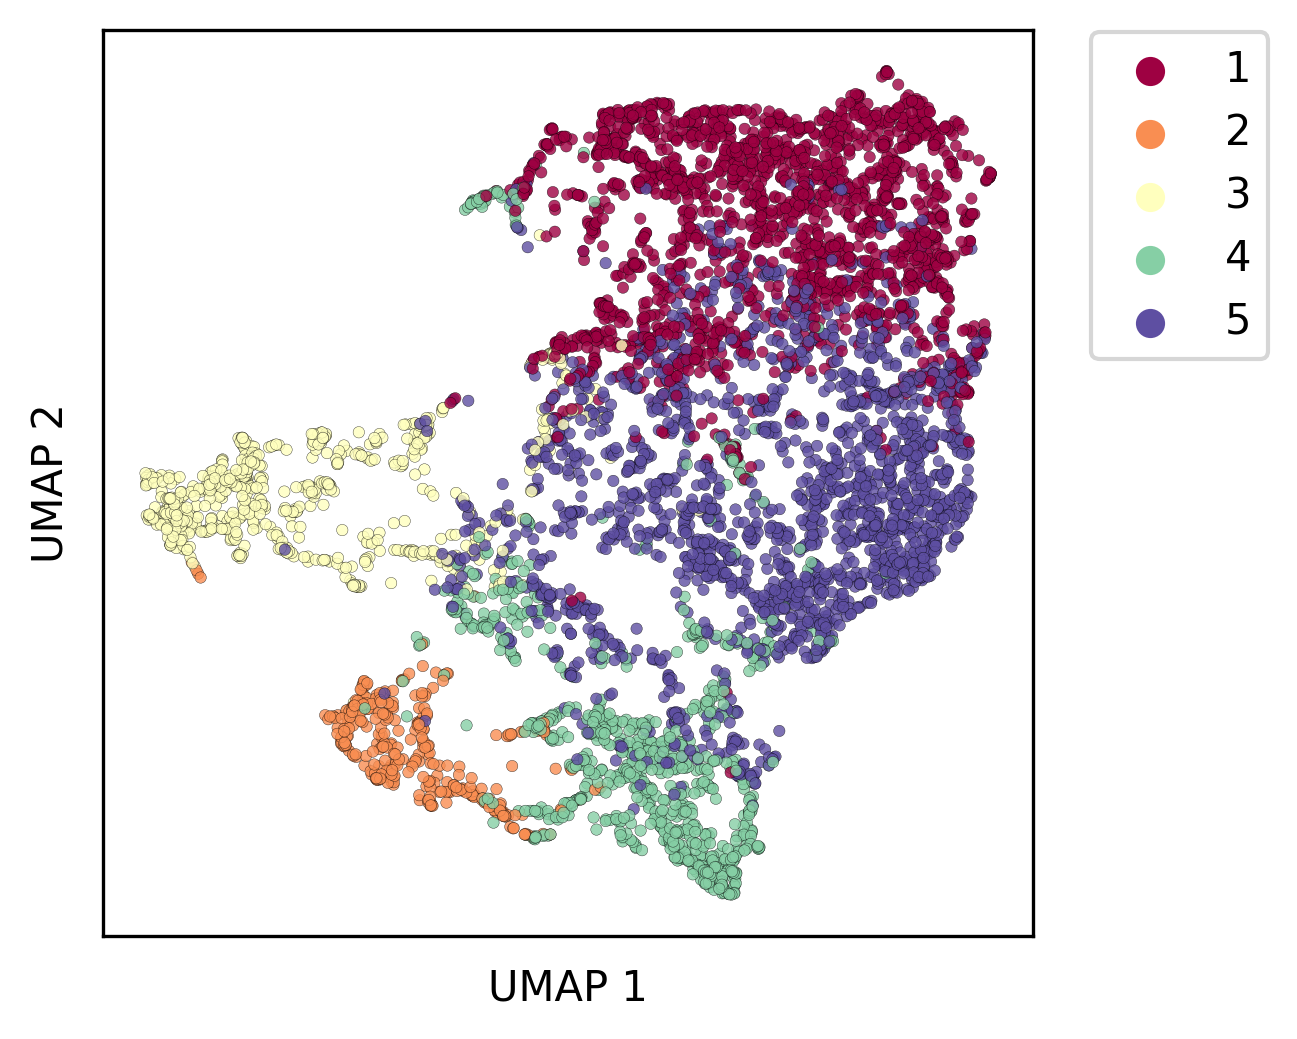

In [124]:
""" recluster the cells using spectral """
k = 5
spect = SpectralClustering(n_clusters=k,
                           affinity='precomputed',
                           assign_labels='discretize',
                           random_state=0).fit(Aknn)

refs['Spectral'] = spect.labels_
print(refs['Spectral'].value_counts())

for cid in refs['Spectral'].unique():
        cluster = refs[refs['Spectral'] == cid]
        print(f"==== {cid+1} n={len(cluster)}===")
        print(cluster['key'].value_counts(normalize=True))
        print()
        
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 4, 4

pdf = embedding.copy()
pdf['Cluster'] = refs['Spectral'].to_list() 
pdf['Cluster'] = pdf['Cluster'] + 1

sns.scatterplot(data=pdf,
                x='x',
                y='y',
                marker=".",
                s=30,
                alpha=0.8,
                linewidth=0.1,
                hue='Cluster',
                edgecolor='k',
                palette='Spectral')

_ = plt.xticks([], [])
_ = plt.yticks([], [])
plt.ylabel("UMAP 2")
plt.xlabel("UMAP 1")
    
plt.legend(bbox_to_anchor=(1.04, 1.02))

In [125]:
"""Save the clustering results """
outpath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/scanpy/macrophageSubtypes.csv"

sf = refs.copy()
sf = sf[['CellId', 'key', 'Spectral', 'ctype']]
sf.columns = ['cellId', 'key', 'clusterId', 'cellType']
sf['subtypeId'] = sf['clusterId'].apply(lambda x: f"M{x+1}")
sf.to_csv(outpath, index=False)
sf.head()

cellId key  clusterId     cellType subtypeId
0  AAAGAACGTCTACAGT-1  ND          3  Macrophages        M4
1  AAAGAACTCCTCGCAT-1  ND          1  Macrophages        M2
2  AAAGGGCGTTAGGGTG-1  ND          2  Macrophages        M3
3  AACAAAGCACCGGCTA-1  ND          2  Macrophages        M3
4  AACAAAGGTTCACGAT-1  ND          4  Macrophages        M5

In [20]:
# """ recluster the cells using spectral """
# k = 6
# spect = SpectralClustering(n_clusters=k,
#                            # affinity='precomputed_nearest_neighbors',
#                            affinity='precomputed',
#                            assign_labels='discretize',
#                            random_state=0).fit(Abbknn)

# refs['Spectral'] = spect.labels_
# print(refs['Spectral'].value_counts())

# for cid in refs['Spectral'].unique():
#         cluster = refs[refs['Spectral'] == cid]
#         print(f"==== {cid} n={len(cluster)}===")
#         print(cluster['key'].value_counts(normalize=True))
#         print()
        
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.facecolor'] = "w"
# plt.rcParams['figure.figsize'] = 4, 4

# plt.scatter(embedding['x'],
#             embedding['y'], 
#             marker=".",
#             s=30,
#             edgecolor='k',
#             lw=0.1,
#             cmap='Spectral',
#             c=refs['Spectral'].to_list(),
#             alpha=0.8)


# _ = plt.xticks([], [])
# _ = plt.yticks([], [])
# plt.ylabel("UMAP 2")
# plt.xlabel("UMAP 1")

==== Cluster 4 NCEH1 ====
	precision=0.0710
	accuracy=0.3922
==== Cluster 2 NCEH1 ====
	precision=0.0143
	accuracy=0.4264
==== Cluster 3 NCEH1 ====
	precision=0.0437
	accuracy=0.3979
==== Cluster 5 NCEH1 ====
	precision=0.3415
	accuracy=0.4881
==== Cluster 1 NCEH1 ====
	precision=0.5295
	accuracy=0.6930


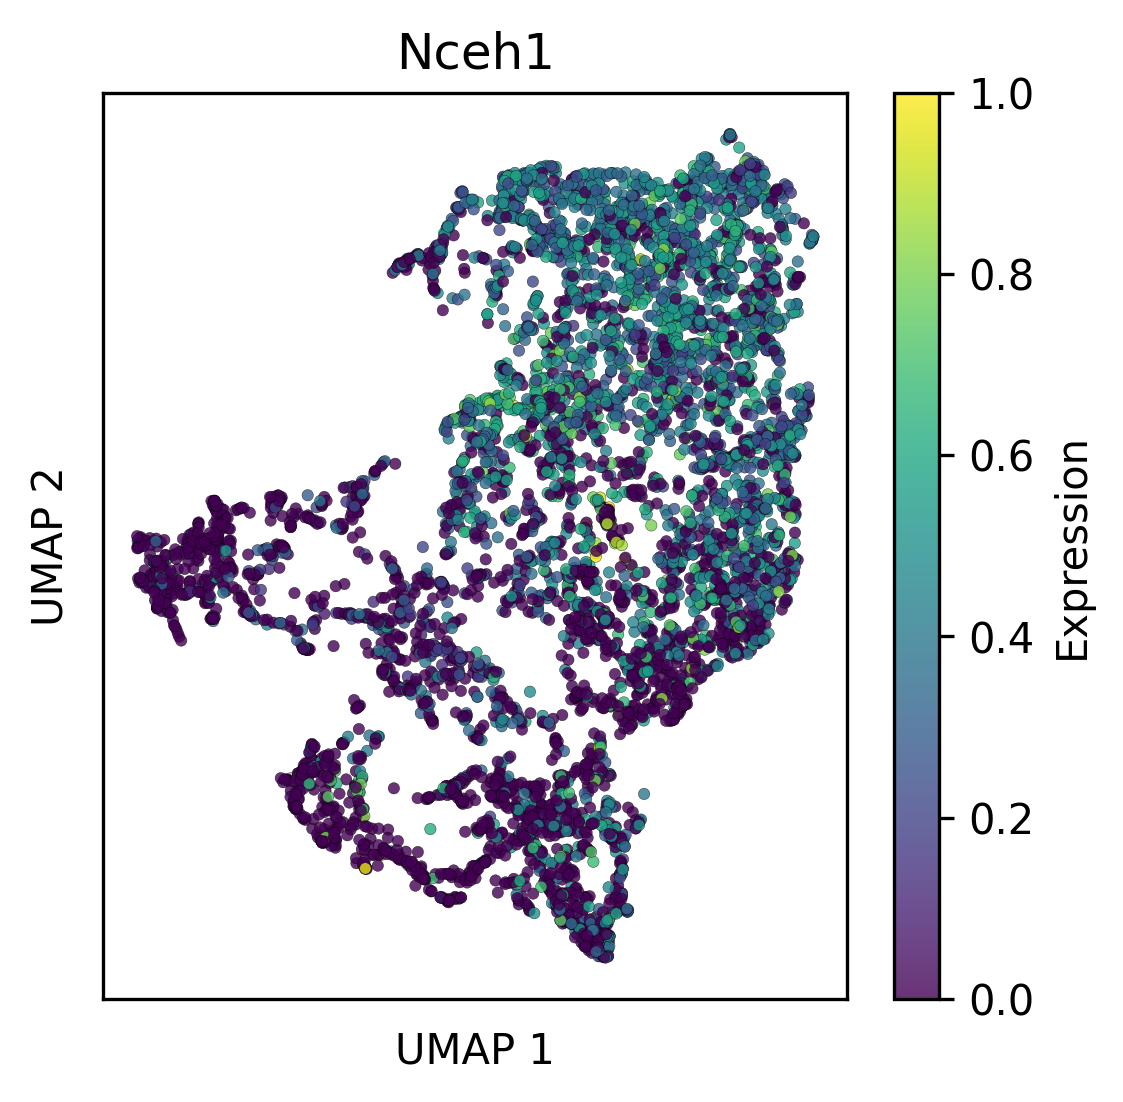

In [169]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 4, 4

query = 'Nceh1'
query = query.upper()

queryVec = res[query].to_numpy()
queryVec *= (1.0/queryVec.max())

y_pred = np.where(queryVec > 0, 1, 0)

plt.scatter(embedding['x'],
            embedding['y'], 
            marker=".",
            s=30,
            edgecolor='k',
            lw=0.1,
            cmap='viridis',
            c=queryVec,
            alpha=0.8)

plt.colorbar(label='Expression')
_ = plt.xticks([], [])
_ = plt.yticks([], [])
plt.ylabel("UMAP 2")
plt.xlabel("UMAP 1")
plt.title(str(query).lower().capitalize())

for c in  refs['Spectral'].unique():
    
    y_true = np.where(refs['Spectral'] == c, 1, 0)
    print(f"==== Cluster {c+1} {query} ====")
    # print(metrics.classification_report(y_true, y_pred))
    accuracy = metrics.accuracy_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    print(f"\t{precision=:.4f}")
    print(f"\t{accuracy=:.4f}")
    

In [22]:
# break

In [143]:
res = res.fillna(0)

deg = []

for cid in refs['Spectral'].unique():
    mask = (refs['Spectral'] == cid)
    
    genes = list(res.columns)
    
    inGroup = res[mask]
    outGroup = res[~mask]
    
    for i, g in enumerate(genes):
        
        scores, pvals = stats.ttest_ind_from_stats(
            mean1=inGroup[g].mean(),
            std1=inGroup[g].std(),
            nobs1=inGroup.shape[0],
            mean2=outGroup[g].mean(),
            std2=outGroup[g].std(),
            nobs2=outGroup.shape[0],
            equal_var=False,  # Welch's
        )
        
        lfc =  np.log(inGroup[g].mean()) - np.log(outGroup[g].mean())
        
        row = {
            'gene' : g,
            'cluster' : cid+1,
            'pval' : pvals,
            'logfoldchange' : lfc,
            'meanGroup' : inGroup[g].mean(),
            'meanOther' : outGroup[g].mean(),
        }
        
        deg.append(row)
    
deg = pd.DataFrame(deg)
deg.head()

/tmp/ipykernel_173734/1184540285.py:25: RuntimeWarning: divide by zero encountered in log
  lfc =  np.log(inGroup[g].mean()) - np.log(outGroup[g].mean())
/tmp/ipykernel_173734/1184540285.py:25: RuntimeWarning: invalid value encountered in float_scalars
  lfc =  np.log(inGroup[g].mean()) - np.log(outGroup[g].mean())


gene  cluster          pval  logfoldchange  meanGroup  meanOther
0   MRPL15        4  2.630174e-11      -0.392057   0.231579   0.342742
1   LYPLA1        4  8.144717e-02      -0.146736   0.150336   0.174096
2    TCEA1        4  9.166254e-07      -0.285828   0.262746   0.349679
3  ATP6V1H        4  3.565092e-11      -0.341313   0.333653   0.469381
4   RB1CC1        4  2.364317e-07       0.334479   0.371776   0.266084

In [161]:
clusterQuery = 2

cdf = deg[deg['cluster'] == clusterQuery]
cdf = cdf.sort_values(by='logfoldchange', ascending=False)
cdf.head(20)

gene  cluster      pval  logfoldchange  meanGroup  meanOther
26700         KHDC1C        2  0.160739            inf   0.004956   0.000000
18733     D6ERTD527E        2  0.317997            inf   0.006304   0.000000
27687           IL13        2  0.317999            inf   0.006250   0.000000
27686  D930048N14RIK        2  0.318000            inf   0.004281   0.000000
27757          FOXJ1        2  0.318000            inf   0.004136   0.000000
27858        CCDC85C        2  0.167529            inf   0.011680   0.000000
27791          CPLX2        2  0.168663            inf   0.011386   0.000000
27136         SLC4A4        2  0.317999            inf   0.002491   0.000000
26875          TTLL9        2  0.317999            inf   0.006483   0.000000
27059         MFSD2A        2  0.318000            inf   0.005924   0.000000
27044         DNAJC6        2  0.320055       5.464215   0.006254   0.000026
27196          PRSS2        2  0.321294       4.994896   0.005310   0.000036
27780        GM47662        2  0.162309       4.836073   0.012321   0.000098
20219        TSPAN15        2  0.322036       4.793677   0.006542   0.000054
22735         FAM83G        2  0.091192       4.521390   0.019307   0.000210
26855         TRIM69        2  0.323894       4.418520   0.004707   0.000057
27887         APOL7B        2  0.097709       4.370173   0.013715   0.000173
27161        GM34086        2  0.181772       4.177007   0.010478   0.000161
28080          GNA14        2  0.187381       4.139194   0.007492   0.000119
27875          CDH10        2  0.327229       3.976625   0.007307   0.000137

In [163]:
alpha = 0.05
lft = 1.5
# db = 'WikiPathways_2019_Mouse'
# db = 'KEGG_2019_Mouse'
db = 'ontology'

for cid in deg['cluster'].unique():
    
    degc = deg[deg['cluster'] == cid]
    
    degc = degc[degc['pval'] <= alpha]
    degc = degc[degc['logfoldchange'] >= lft].reset_index(drop=True)
    
    genes  = degc['gene'].to_list()
    
    pd.set_option('display.max_colwidth', 200)
    ef = gget.enrichr(genes, database=db)
    ef = ef[ef['p_val'] <= alpha].reset_index(drop=True)
    print(f"\n==== {cid} {len(genes)=} ====")
    print(ef['path_name'])

Thu Dec 22 10:32:51 2022 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    
Thu Dec 22 10:32:52 2022 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    



==== 4 len(genes)=200 ====
0                                            regulation of humoral immune response (GO:0002920)
1                                                                B cell chemotaxis (GO:0035754)
2                                                               hypotonic response (GO:0006971)
3      positive regulation of vascular associated smooth muscle cell proliferation (GO:1904707)
4                                                            lymphocyte chemotaxis (GO:0048247)
                                                 ...                                           
209                                                tonic smooth muscle contraction (GO:0014820)
210                        microtubule nucleation by microtubule organizing center (GO:0051418)
211                                                       postsynaptic endocytosis (GO:0140239)
212                         postsynaptic neurotransmitter receptor internalization (GO:0098884)
213         

Thu Dec 22 10:32:52 2022 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    



==== 2 len(genes)=159 ====
0                       positive regulation of T cell activation (GO:0050870)
1                     positive regulation of cytokine production (GO:0001819)
2                           regulation of T cell differentiation (GO:0045580)
3                                          inflammatory response (GO:0006954)
4                                              T cell activation (GO:0042110)
                                        ...                                  
527                  positive regulation of biosynthetic process (GO:0009891)
528                           positive regulation of cell growth (GO:0030307)
529    positive regulation of cellular protein metabolic process (GO:0032270)
530               positive regulation of vasculature development (GO:1904018)
531                     negative regulation of T cell activation (GO:0050868)
Name: path_name, Length: 532, dtype: object


Thu Dec 22 10:32:53 2022 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    



==== 3 len(genes)=445 ====
0                                regulation of immune response (GO:0050776)
1              regulation of regulatory T cell differentiation (GO:0045589)
2                            indolalkylamine catabolic process (GO:0046218)
3                                 tryptophan catabolic process (GO:0006569)
4                                 tryptophan metabolic process (GO:0006568)
                                       ...                                 
141                              dendritic spine morphogenesis (GO:0060997)
142                     glycosphingolipid biosynthetic process (GO:0006688)
143               negative regulation of macrophage activation (GO:0043031)
144    positive regulation of small molecule metabolic process (GO:0062013)
145                                  response to retinoic acid (GO:0032526)
Name: path_name, Length: 146, dtype: object


Thu Dec 22 10:32:53 2022 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    



==== 5 len(genes)=13 ====
0                                   cerebral cortex cell migration (GO:0021795)
1                                     telencephalon cell migration (GO:0022029)
2                                    protein retention in ER lumen (GO:0006621)
3     maintenance of protein localization in endoplasmic reticulum (GO:0035437)
4                  negative regulation of myoblast differentiation (GO:0045662)
5             regulation of voltage-gated calcium channel activity (GO:1901385)
6                                   cilium-dependent cell motility (GO:0060285)
7                               neuromuscular junction development (GO:0007528)
8     regulation of calcium ion transmembrane transporter activity (GO:1901019)
9                                          membrane depolarization (GO:0051899)
10                          regulation of myoblast differentiation (GO:0045661)
11                           regulation of transmembrane transport (GO:0034762)
12           

In [ ]:
break

In [ ]:
"""Leiden clustering """
sources, targets = Aknn.nonzero()
weights = Aknn[sources, targets]
if isinstance(weights, np.matrix):
    weights = weights.A1
g = ig.Graph(directed=False)
g.add_vertices(Aknn.shape[0])  # this adds adjacency.shape[0] vertices
g.add_edges(list(zip(sources, targets)))
g.es['weight'] = weights

weights = np.array(g.es['weight']).astype(np.float64)
resolution_parameter = 0.2

partition = la.find_partition(g, 
                              la.RBConfigurationVertexPartition, 
                              weights=weights, 
                              resolution_parameter=resolution_parameter);

groups = np.array(partition.membership)
print(np.std(groups))
print(groups)

""" recluster the cells """


pdf = embedding.copy()
pdf['Cluster'] = groups
pdf['Cluster'] = pdf['Cluster'] + 1

sns.scatterplot(data=pdf,
                x='x',
                y='y',
                marker=".",
                s=30,
                alpha=0.8,
                linewidth=0.1,
                hue='Cluster',
                edgecolor='k',
                palette='Spectral')

_ = plt.xticks([], [])
_ = plt.yticks([], [])
plt.ylabel("UMAP 2")
plt.xlabel("UMAP 1")

plt.legend(bbox_to_anchor=(1.04, 1.02))

In [ ]:
break

In [ ]:
# Ahat = A.copy()
# Ahat *= 1.0/Ahat.max() 

# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.facecolor'] = "w"
# plt.rcParams['figure.figsize'] = 5, 5


# plt.matshow(Ahat, cmap='hot')
# _ = plt.xticks([])
# _ = plt.yticks([])
# plt.colorbar(fraction=0.0472, pad=0.01, label='Distance')
# plt.xlabel("Cells")
# plt.ylabel("Cells")

In [ ]:
# def getA(X, r, metric='euclidean'):
#     """A function to get the distance matrix A.
#     Expected a centered data matrix"""
    
#     Xc = X.fillna(0).apply(lambda x: x-x.mean())
#     Xc = Xc.to_numpy()
    
#     # SVD
#     u, s, v = np.linalg.svd(Xc)
    
#     # construct P
#     P = u[:, 0:r]
    
#     # build distance matrix
#     return squareform(pdist(P, metric=metric))
    
    
# A = getA(res, r=15)
# plt.matshow(A)